In [1]:
from pathlib import Path
import pandas as pd
from itertools import zip_longest
import torch
from tqdm import tqdm
from transformers import AutoModel, AutoTokenizer

assert torch.cuda.is_available()


# from the itertools examples
def grouper(iterable, n, *, incomplete="fill", fillvalue=None):
    "Collect data into non-overlapping fixed-length chunks or blocks"
    # grouper('ABCDEFG', 3, fillvalue='x') --> ABC DEF Gxx
    # grouper('ABCDEFG', 3, incomplete='strict') --> ABC DEF ValueError
    # grouper('ABCDEFG', 3, incomplete='ignore') --> ABC DEF
    args = [iter(iterable)] * n
    if incomplete == "fill":
        return zip_longest(*args, fillvalue=fillvalue)
    if incomplete == "strict":
        return zip(*args, strict=True)
    if incomplete == "ignore":
        return zip(*args)
    else:
        raise ValueError("Expected fill, strict, or ignore")



/home/cpbotha/.cache/pypoetry/virtualenvs/org-roam-umap-ICgQtweM-py3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

device = "cuda:0"
# vs base
model_name = "jinaai/jina-embeddings-v2-small-en"
model = AutoModel.from_pretrained(
    model_name, trust_remote_code=True
)  # trust_remote_code is needed to use the encode method
model.to(device)


JinaBertModel(
  (embeddings): JinaBertEmbeddings(
    (word_embeddings): Embedding(30528, 512, padding_idx=0)
    (token_type_embeddings): Embedding(2, 512)
    (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): JinaBertEncoder(
    (layer): ModuleList(
      (0-3): 4 x JinaBertLayer(
        (attention): JinaBertAttention(
          (self): JinaBertSelfAttention(
            (query): Linear(in_features=512, out_features=512, bias=True)
            (key): Linear(in_features=512, out_features=512, bias=True)
            (value): Linear(in_features=512, out_features=512, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): JinaBertSelfOutput(
            (dense): Linear(in_features=512, out_features=512, bias=True)
            (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
 

In [35]:
import datetime
import yaml

def strip_header(markdown: str):
    """Strip '---'-delineated header from the passed markdown"""
    _, front_matter, markdown = markdown.split("---", 2)
    fm = yaml.safe_load(front_matter)
    markdown = f"title: {fm['title']}" + markdown
    mtime = datetime.datetime.fromisoformat(fm['mtime'])

    return mtime, markdown


strip_header("---\ntitle: bleh\nmtime: 2022-09-24T15:42:52+0200\n---\nhello there")



(datetime.datetime(2022, 9, 24, 15, 42, 52, tzinfo=datetime.timezone(datetime.timedelta(seconds=7200))),
 'title: bleh\nhello there')

# Embed the exported notes

On this RTX2070 with 8GB of VRAM, via WSL2, processing 1700 org-roam nodes with jina small takes 1m15s.

In [10]:
# in the jina documentation they mention a batch size of 32
# before I knew that, I experimented with batching more than one doc from this side
# for jina-base, batch_size=1 was the fatsest doh
batch_size = 1 
embs = {}
mtimes = {}
all_files = list(Path("/tmp/bleh").glob("*.md"))
for chunk in tqdm(
    grouper(Path("/tmp/bleh/").glob("*.md"), batch_size), desc="embedding docs", total=len(all_files) // batch_size
):
    input_texts = []
    for f in chunk:
        mtime, md = strip_header(f.open().read())
        input_texts.append(md)
        mtimes[str(f)] = mtime

    embs_ = model.encode(input_texts)
    for f,e in zip(chunk, embs_):
        embs[str(f)] = e


# dict key should be row index, hence index
df = pd.DataFrame.from_dict(embs, orient="index")
# PosixPath confuses parquet, so convert to string
#df.index = df.index.astype(dtype="string")

# write out the embeddings
df.to_parquet("embs_jina_small.parq")

# write out the modified times of the files
df_mtimes = pd.DataFrame.from_dict(mtimes, orient="index")
df_mtimes.to_parquet("mtimes.parq")

embedding docs: 100%|██████████| 1704/1704 [01:15<00:00, 22.59it/s]


<Axes: >

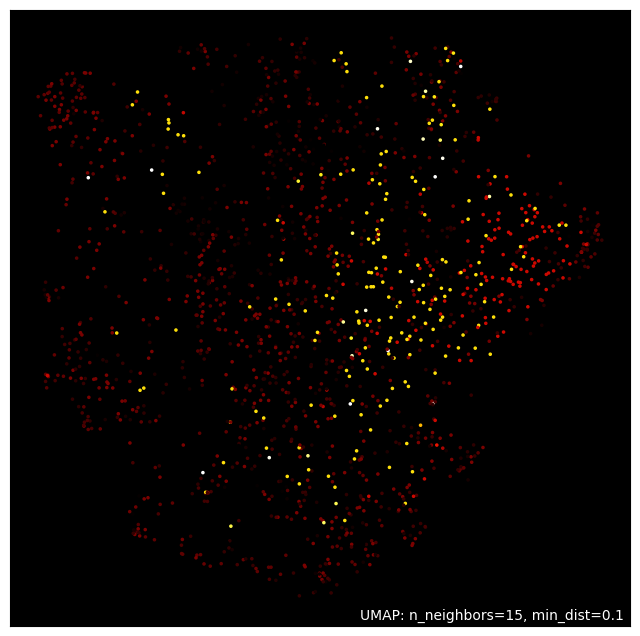

In [12]:
import datetime
import pandas as pd
import umap
import umap.plot

df = pd.read_parquet("embs_jina_small.parq")
df_mtimes = pd.read_parquet("mtimes.parq")

# ensure element-wise equality between the two indices, which should be a corresponding list of filenames
assert df.index.equals(df_mtimes.index)

# calculate ages based on time now, using the timestamps in df_mtimes
note_age = - (df_mtimes[0] - datetime.datetime.now(tz=datetime.timezone.utc))
mapper = umap.UMAP().fit(df)



In [41]:
from pathlib import Path
hover_data = pd.DataFrame({"filename": df.index})
previews = []
for fn in hover_data["filename"]:
    previews.append(strip_header(Path(fn).open().read(512))[1])
# IMPORTANT: comment out this line and re-run this cell if you're going to share your notebook
#            or you might leak some private information!
#hover_data["preview"] = previews

umap.plot.output_notebook()
p = umap.plot.interactive(mapper, values=note_age.dt.total_seconds().values, point_size=5, hover_data=hover_data, tools=["pan","wheel_zoom","box_zoom","save","reset","help",])
umap.plot.show(p)

Loading BokehJS ...